# Taller 3

In [49]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm
import sympy as sym 
import random as rand
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import qexpy as q
from scipy import integrate
from scipy.integrate import odeint

### 1.

##### a)

In [50]:
def System(r,t):
    x=r[0]
    y=r[1]
    
    dx=2*x-y
    dy=x+2*y
    
    return np.array([dx,dy])

In [51]:
def IntegratorAdams(f,r0,t):
    
    
    x = np.zeros_like(t)
    vx = np.zeros_like(t)
    
    x[0] = r0[0]
    vx[0] = r0[1]
    
    K11 = np.zeros(2)
    K12 = np.zeros(2)
    
    present = np.array([x[0],vx[0]])
    K11 = f(present,t[0])
    
    # Euler
    x[1] = x[0] + h*K11[0]
    vx[1] = vx[0] + h*K11[1]
    
    xc = x.copy()
    vxc = vx.copy()
    
    for i in range(2,len(t)):
        
        present = np.array([x[i-1],vx[i-1]])
        past = np.array([x[i-2],vx[i-2]])
        
        K11 = f(present,t[i-1])
        K12 = f(past,t[i-2])
        
        x[i] = x[i-1] + 0.5*h*(3*K11[0]-K12[0])
        vx[i] = vx[i-1] + 0.5*h*(3*K11[1]-K12[1])
        
        xc[i] = x[i]
        vxc[i] = vx[i]
        
        # Futuro
        futuro = np.array([x[i],vx[i]])
        K13 = f(futuro,t[i])
        
        xc[i] = xc[i-1] + h*(5*K13[0]+8*K11[0]-K12[0])/12
        vxc[i] = vxc[i-1] + h*(5*K13[1]+8*K11[1]-K12[1])/12
    
    return x,vx,xc,vxc

In [52]:
t=np.linspace(0,5,1000)
h = t[1] - t[0]
r0=[0.-h,0.-h]
sol=odeint(System,r0,t)
sol2=IntegratorAdams(System,r0,t)


solx=sol[:,0]
soly=sol[:,1]
sol2x,sol2y,sol2vx,sol2vy=sol2


<IPython.core.display.Javascript object>


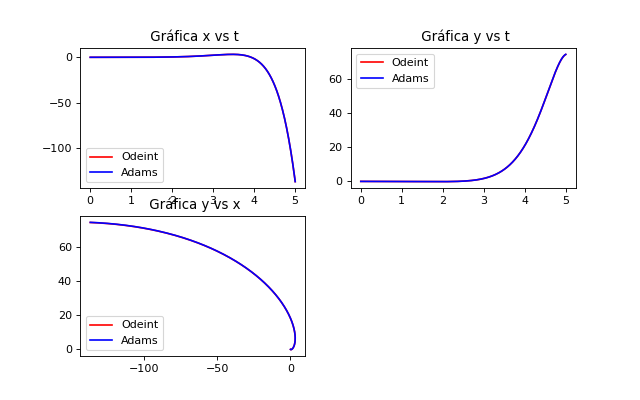

In [53]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)



ax.plot(t,solx,color="red", label="Odeint")
ax.plot(t,sol2x,color="blue", label="Adams")

ax1.plot(t,soly,color="red", label="Odeint")
ax1.plot(t,sol2y,color="blue", label="Adams")

ax2.plot(solx,soly,color="red", label="Odeint")
ax2.plot(sol2x,sol2y,color="blue", label="Adams")

ax.set_title(' Gráfica x vs t')
ax1.set_title(' Gráfica y vs t')
ax2.set_title(' Gráfica y vs x')
ax.legend()
ax1.legend()
ax2.legend()

#### b)

Partiendo del sistema autónomo lineal:

$$
x'=2x-y\\
y'=x+2y
$$

y que la matriz de estabilidad está dada por:

$$
\begin{equation}
\begin{pmatrix}
\frac{\partial f(q_0,p_0)}{\partial q}&\frac{\partial f(q_0,p_0)}{\partial p}\\
\frac{\partial g(q_0,p_0)}{\partial q}&\frac{\partial g(q_0,p_0)}{\partial p}
\end{pmatrix}
\end{equation}
$$

Entonces, teniendo en cuenta que para este sistema la función $f$ es $2x-y$ y $g$ es $x+2y$, la matriz de estabilidad para este sistema estaría dada por:

$$
\begin{equation}
\begin{pmatrix}
2&-1\\
1&2
\end{pmatrix}
\end{equation}
$$



#### c)

In [54]:
M=np.array([[2,-1],[1,2]])

In [55]:
np.linalg.eig(M)

(array([2.+1.j, 2.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        -0.70710678j, 0.        +0.70710678j]]))

#### d)

<IPython.core.display.Javascript object>


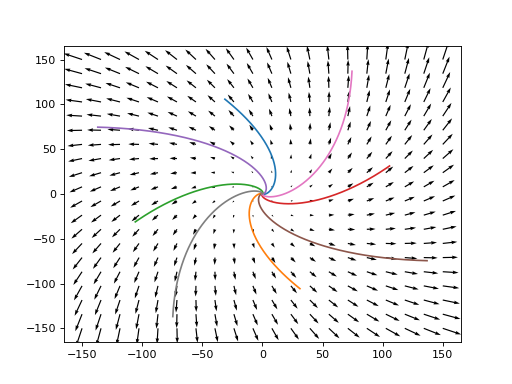

In [56]:
fig=plt.figure()
ax=fig.add_subplot()

rs=[(0-h,0),(0+h,0),(0,0-h),(0,0+h),(0-h,0-h),(0+h,0+h),(0-h,0+h),(0+h,0-h)]


for i in rs:
    sols=IntegratorAdams(System,i,t)
    ax.plot(sols[0],sols[1])
    
xlimit=np.linspace(-150,150,20)
ylimit=np.linspace(-150,150,20)

r0s=[sol2x,sol2y]
x,y=np.meshgrid(xlimit,ylimit)
sysx=System([x,y],t)[0]
sysy=System([x,y],t)[1]

ax.quiver(x,y,sysx,sysy)

    

El punto crítico es en (0,0)

### 2.

In [63]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v
        
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale] 
    
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(3):
            
            if self.r[i] + self.radius > 10 and self.v[i] > 0.:
                self.v[i] = -self.v[i]
            elif self.r[i] - self.radius < -10 and self.v[i] < 0.:
                self.v[i] = -self.v[i]


In [64]:
def GetFiftyParticles(N,t):
    i=0
    FiftyParticles=[]
    
    #PASAR A 50
    
    while i<50:
        r=np.array([rand.uniform(-10.,10.),rand.uniform(-10.,10.),rand.uniform(-10.,10.)])
        v=np.array([rand.uniform(-5.,5.),rand.uniform(-5.,5.),rand.uniform(-5.,5.)])
        a=np.array([0.,0.,0.])
        particle=Particle(r,v,a,t,m=1,radius=0.1,Id=i)
        
        i+=1
        FiftyParticles.append(particle)
        
    return FiftyParticles

In [65]:
#PASO
dt = 0.01
tmax = 20
t = np.arange(0,tmax,dt)
Particles = GetFiftyParticles(1,t)

In [66]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [67]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 2000/2000 [00:32<00:00, 61.07 Steps/s]


In [68]:
scale = 50
t1 = t[::scale]

<IPython.core.display.Javascript object>


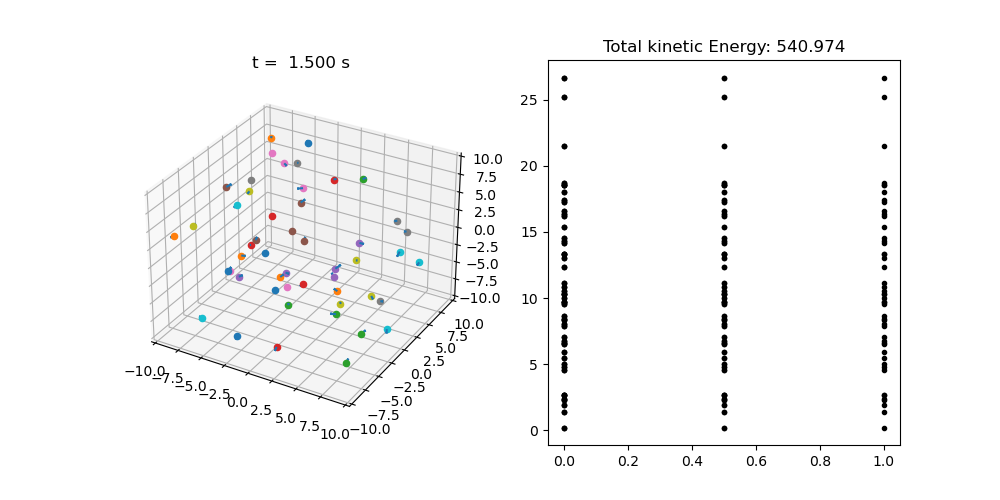

In [69]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121,projection='3d')
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    ax.set_zlim(-10,10)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        z = p.GetPosition(scale)[i,2]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        vz = p.GetVelocity(scale)[i,2]
        
        circle = plt.Circle( (x,y,z), p.radius, color='r', fill=False )
        ax.quiver(x,y,z,vx,vy,vz,length=0.1)
        ax.scatter(x,y,z)
         
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)


### 3.

#### a)

#### b)

Tenemos un disco que gira por un eje que pasa por el centro y es perpendicular a su plano.

Resolviendo por medio de integración se tiene que:
$$
\begin{align*}
I=\int r^2 \,dm
\end {align*}
$$


Donde  dm el diferencial de masa.


Para expresar el diferencial de masa en terminos de un diferencial de radio haremos uso de la fórmula de densidad. 
$$
\begin{align*}
\rho =\frac{dm}{dA}
\end {align*}
$$

Con $dA $ diferencial de area con valor de $2\pi r dr$

Despejando de la ecuación de densidad se obtiene que:


$$
\begin{align*}
dm&=\frac{m2\pi r dr}{\pi R^2}\\
&=\frac{m2 r dr}{R^2}
\end {align*}
$$


Al meter esta expresión en la integral, se llega a que:

$$
\begin{align*}
I=\int r^2 \,\frac{m2 r }{R^2}dr
\end {align*}
$$

Con R siendo el radio del disco, como una constante,

$$
\begin{align*}
I=\frac{2 m }{R^2}\int_{0}^{R} r^3 \,dr
\end {align*}
$$

Donde esta integral se refiere a todos los círculos con espesor diferencial $r$ que forman el disco.

Resolviendo la integral: 
$$
\begin{align*}
I&=\frac{2mr^4}{R^2}\Big |_0^R\\
&=\frac{mR^4}{2R^2}-\frac{mO^4}{2R^2}\\
&=\frac{mR^2}{2}\\
\end {align*}
$$

#### c)

#### i)
Para demostrar la expresión de $$\frac{\partial L}{\partial \dot \phi}$$, se realiza la derivada parcial del Lagrangiano en función de $\dot \phi$, de modo que se tiene lo siguiente:

$$
L=\frac{1}{2}I_0(\dot \theta^2 +\dot \phi^2 sin^2\theta)+\frac{1}{2}I_z(\dot \phi cos\theta +\dot \psi)^2 -mgdcos\theta
$$

$$
\begin{align*}
\frac{\partial L}{\partial \dot \phi}&=I_0\dot \phi sin^2\theta +I_z(\dot\phi cos\theta+\dot \psi) cos\theta\\
&=I_0\dot \phi sin^2\theta +I_z \phi cos^2\theta + I_z\dot \psi cos\theta\\
&=\dot \phi (I_0sin^2\theta + I_zcos^2\theta)+I_z\dot\psi cos\theta
\end{align*}
$$

dado que, para que se cumplan las ecuaciones de Euler-Lagrange se debe cumplir que el término $$\frac{\partial L}{\partial \dot \phi}$$, sea una constante. De este manera,

$$
\frac{\partial L}{\partial \dot \phi}=\dot \phi (I_0sin^2\theta + I_zcos^2\theta)+I_z\dot\psi cos\theta=p_\phi
$$

#### ii)
Para demostrar la expresión de $$\frac{\partial L}{\partial \dot \psi}$$, se realiza la derivada parcial del Lagrangiano en función de $\dot \psi$, al igual que en la demostración anterior, de modo que se tiene lo siguiente:

$$
\begin{align*}
\frac{\partial L}{\partial \dot \psi}&=I_z(\dot \phi^2 cos\theta +\dot \psi)
\end{align*}
$$

dado que, para que se cumplan las ecuaciones de Euler-Lagrange se debe cumplir que el término $$\frac{\partial L}{\partial \dot \psi}$$, sea una constante. De este manera,

$$
\frac{\partial L}{\partial \dot \psi}=I_z(\dot \phi^2 cos\theta +\dot \psi)=p_\psi
$$

#### iii)

Para demostrar la expresión de $I_0\ddot \theta$, se parte de plantear la derivadas parciales del lagrangiano en función de $\theta$, $\ddot \theta$. De modo que se tiene lo siguiente:

$$
\frac{\partial L}{\partial \dot  \theta}=I_0\dot \theta
$$

$$
\frac{d}{dt}\frac{\partial L}{\partial \dot  \theta}=I_0\ddot \theta
$$

$$
\begin{align*}
\frac{\partial L}{\partial \theta}&=I_0 \dot \phi^2 sin\theta cos\theta -I_z(\dot \phi^2 cos\theta +\dot \psi)\dot \phi sin\theta +mgdsin\theta\\
&=\dot \phi^2 sin\theta cos\theta(I_0-I_z) -I_z\dot \psi \dot \phi sin\theta +mgdsin\theta
\end{align*}
$$

De esta manera, al poner estas expresiones en la ecuación de Euler-Lagrange, se llega a lo siguiente:

$$
\begin{align*}
\frac{d}{dt} \frac{\partial L}{\partial \dot \theta}&=\frac{\partial L}{\partial \theta}\\
I_0 \ddot \theta&=\dot \phi^2 sin\theta cos\theta(I_0-I_z) -I_z\dot \psi\dot \phi sin\theta +mgdsin\theta
\end{align*}
$$


#### d) 

#### e)

In [88]:
g=9.81
t2=np.linspace(0.,8.,10000)
m=0.1
r=0.1
d=0.3
dpsi0=400
y0=np.array([0.,0.,np.pi/4,0.])

def System (y0,t,r,d,m,dpsi):
    
    theta_0=np.pi/4
    phi=y0[0]
    psi=y0[1]
    theta=y0[2]
    dtheta=y0[3]
    
    I_0=(1/4)*m*r**2 +m*d**2
    I_z=(1/2)*m*r**2
    
    dpsi=dpsi
    dtheta=dtheta
    
    dphi=(I_z*dpsi*(np.cos(theta_0)-np.cos(theta)))/(
        I_0*np.sin(theta)**2 + I_z*np.cos(theta)**2)

    
    ddtheta= (dphi**2*np.sin(theta)*np.cos(theta)*(I_0-I_z)
              -dphi*dpsi*I_z*np.sin(theta) +m*g*d*np.sin(theta))/I_0
    

    return [dpsi,dphi,dtheta,ddtheta]
    

In [89]:
sol=odeint(System,y0,t2,args=(r,d,m,dpsi0))

In [90]:
dpsi=sol[:,0]
dphi=sol[:,1]
dtheta=sol[:,2]
ddtheta=sol[:,3]

dpsi

array([0.00000000e+00, 3.20032003e-01, 6.40064006e-01, ...,
       3.19935994e+03, 3.19967997e+03, 3.20000000e+03])

<IPython.core.display.Javascript object>


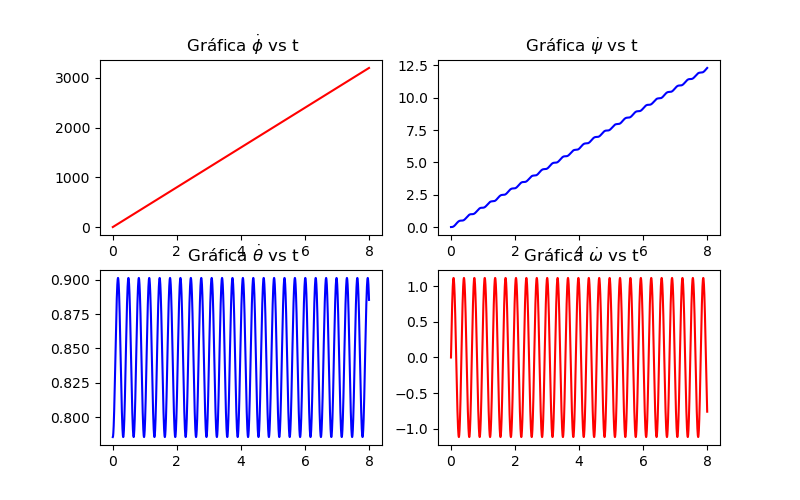

Text(0.5, 1.0, ' Gráfica $\\dot \\omega$ vs t')

In [91]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)



ax.plot(t2,dpsi,color="red")
ax1.plot(t2,dphi,color="blue")
ax2.plot(t2,dtheta,color="blue")
ax3.plot(t2,ddtheta,color="red")

ax.set_title(' Gráfica $\dot \phi$ vs t ')
ax1.set_title(' Gráfica $\dot \psi$ vs t')
ax2.set_title(' Gráfica $\dot θ $ vs t')
ax3.set_title(' Gráfica $\dot \omega$ vs t')

#### f)

In [92]:

puntosx=np.zeros(len(t))
puntosy=np.zeros(len(t))
puntosz=np.zeros(len(t))
for i in range(len(t)):
    puntosx[i]=d*np.cos(dphi[i])*np.sin(dtheta[i])
    puntosy[i]=d*np.sin(dphi[i])*np.sin(dtheta[i])
    puntosz[i]=d*np.cos(dtheta[i])   
    

scale = 20
t1 = t[::scale]

<IPython.core.display.Javascript object>


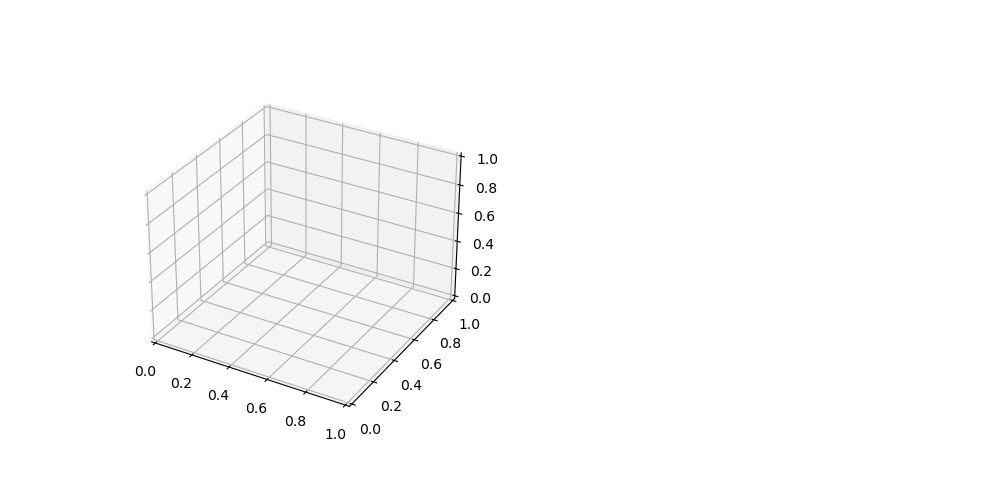

In [93]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(121,projection='3d')

def init():
    
    ax.clear()
    ax.set_xlim(-0.2,0.2)
    ax.set_ylim(-0.2,0.2)
    ax.set_zlim(-0.2,0.2)
    
def Update(i):
    
    init()
    
        
    x=puntosx[::scale][i]
    y=puntosy[::scale][i]
    z=puntosz[::scale][i]
        
        
    ax3.scatter(x,y,z)
    ax3.plot([0,x], [0,y],[0,z], 'o-', lw=2,c="b")
    
Animation = anim.FuncAnimation(fig3,Update,frames=len(t1),init_func=init)

#### g)

### 4. Viaje a la Luna

#### a)

In [81]:
w=2.6617e-6


#### b)

In [82]:
G=6.67e-11
m_T=5.9736e24
r_T=6.3781e6
m_L=0.07349e24
r_L=1.7374e6
d=3.844e8

#### c)

Como la posición de la nave, la luna y la tierra en la gráfica forman un triángulo, es posible hacer uso de la ley de cosenos que  dice que: 

$$
\begin{align*}
A^2&=B^2+C^2-2BC cos(\alpha)\\
A&=\sqrt{B^2+C^2-2BC cos(\alpha)}
\end {align*}
$$

Donde, para el presente ejercicio $B$ La distancia de la tierra a la nave(r(t)), $C$ corresponde a la distancia de la tierra a la luna($d$), $\alpha$ es el ángulo entre la luna y la nave, dado por $\phi - wt$ y $A$ es la distancia entre la luna y la nave, que es lo que pensamos encontrar(rl).

Reescribiendo esta expresión con nuestras variables se llega a que: 
$$
\begin{align*}
r_L=\sqrt{r(t)^2+d^2-2r(t)d cos(\phi - wt)}
\end {align*}
$$


#### d)

Se tiene que
$$
\begin{align*}
p_r=m\dot{r}\\
y \\
p_\phi=m\dot{\phi}r^2
\end {align*}
$$



Además, sea $L=T-U$, donde T es la energía cinética y U la energía potencial. Entonces, 

$$
\begin{align*}
T=\frac{mv^2}{2}\\
\end {align*}
$$
Para escribir esta fórmula es necesario conocer el vector posición y derivarlo. Al tratarse de movimiento "circular" es preferible usar coordenadas polares. \\
Por ende, 
$$
\begin{align*}
\vec{r}&=rcos(\phi) \widehat{i}+ rsin(\phi)\widehat{j}\\
\dot{\vec{r}}&=(\dot{r}cos(\phi)-rsin(\phi)\phi)\widehat{i}+(\dot{r}sin(\phi)+rcos(\phi)\phi)\widehat{j}\\
\dot{\vec{r}}^2&= \dot{r}^2+r^2\dot{\phi}^2
\end {align*}
$$
Que al meterlo en la fórmula de T se llega a:

$$
\begin{align*}
T=\frac{m(\dot{r}^2+r^2\dot{\phi}^2)}{2}\\
\end {align*}
$$

Ahora, falta encontrar la energía potencial gravitacional.
$$
\begin{align*}
U=\frac{-GmM}{r}\\
\end {align*}
$$
Pero hay que tener en cuenta que la nave siente atracción gravitacional tanto de la tierra como de la luna, es decir:
$$
\begin{align*}
U=-(\frac{Gmm_t}{r}+\frac{Gmm_l}{r_l})\\
\end {align*}
$$

Ya conociendo T y U podemos encontrar el lagrangiano  y con ello encontrar el hamiltoniano. 
$$
\begin{align*}
L=\frac{m(\dot{r}^2+r^2\dot{\phi}^2)}{2}+\frac{Gmm_t}{r}+\frac{Gmm_l}{r_l}\\
\end {align*}
$$


$$
\begin{align*}
H=p_r\dot{r}+p_\phi\dot{\phi}-L
H=m\dot{r}\dot{r}+m\dot{\phi}r^2\dot{\phi}-(\frac{m(\dot{r}^2+r^2\dot{\phi}^2)}{2}+\frac{Gmm_t}{r}+\frac{Gmm_l}{r_l})\\
H=\frac{p_r^2}{2m}+\frac{p_\phi^2}{2mr^2}-\frac{Gmm_t}{r}-\frac{Gmm_l}{r_l}\\
\end {align*}
$$

#### e)

Partiendo de la expresión del Hamiltoniano demostrada en el inciso d, se realizan las derivadas respecto a $p_r$, $p_\phi$, $r$ y $\phi$, de modo que se se obtiene lo siguiente:

#### i)

$$
\begin{align*}
\dot r&=\frac{\partial H}{\partial p_r}\\
&= \frac{2p_r}{2m}\\
&=\frac{p_r}{m}
\end{align*}
$$


#### ii)

$$
\begin{align*}
\dot \phi&=\frac{\partial H}{\partial p_\phi}\\
&= \frac{2p_\phi}{2mr^2}\\
&=\frac{p_\phi}{mr^2}
\end{align*}
$$

#### iii)

$$
\begin{align*}
\dot p_r&=-\frac{\partial H}{\partial r}\\
&= \frac{p_\phi}{mr^3}-\frac{Gmm_T}{r^2}-\frac{Gmm_L}{2(r^2+d^2-2rdcos(\phi-\omega t))^{3/2})}(2r-2dcos(\phi -\omega t))\\
&=\frac{p_\phi}{mr^3}-\frac{Gmm_T}{r^2}-\frac{Gmm_L}{r_L(r,\phi,t)^3}(r-dcos(\phi -\omega t))
\end{align*}
$$

#### iv)

$$
\begin{align*}
\dot p_\phi&=-\frac{\partial H}{\partial \phi}\\
&=-\frac{Gmm_L}{2(r^2+d^2-2rdcos(\phi-\omega t))^{3/2}} (2rdsin(\phi-\omega t))\\
&=-\frac{Gmm_L}{r_L(r,\phi,t)^3} rdsin(\phi-\omega t)
\end{align*}
$$

#### f)

Para demostrar cada expresión, se parte de las definiciones de las variables normalizadas ($\tilde{r}=r/d$, $\phi$, $\tilde{p_r}=p_r/md$ y $\tilde{p_\phi}=p_\phi/md^2$)

#### i)

Para demostrar $\tilde{\dot r}$, se tiene:

$$
 \tilde{\dot r}=\frac{\dot r}{d}=\frac{p_r}{md}=\tilde{p_r}
$$

#### ii)

Para demostrar $\dot \phi$, se tiene:

$$
\dot \phi= \frac{p_\phi}{mr^2}=\frac{p_\phi}{md^2 \tilde{r}^2}=\frac{md^2\tilde{p_\phi}}{md^2 \tilde{r}^2}=\frac{\tilde{p_\phi}}{\tilde{r}^2}
$$

#### iii)

Para demostrar $\tilde {\dot p_r}$, se puede partir de la expresión de $r_L(r,\phi,t)$, de modo que se tiene que,


$$
\begin{align*}
r_L(r,\phi,t)&=(r^2+d^2-2rdcos(\phi-\omega t))^{1/2}\\
&=(d^2\tilde{r}^2+d^2-\tilde{r}d^2cos(\phi-\omega t))^{1/2}\\
&=d(1+\tilde{r}^2 -2rcos(\phi-\omega t))^{1/2} =\tilde{r}'
\end{align*}
$$

Por consiguiente, se tiene,

$$
\begin{align*}
\tilde{\dot p_r}&= \frac{p_\phi}{mr^3}-\frac{Gmm_T}{r^2}-\frac{Gmm_L}{d\tilde{r}'}(r-dcos(\phi -\omega t))\\
&=\frac{\tilde{p_\phi}^2 m^2d^4}{m\tilde{r}^3d^3}-\frac{Gmm_T}{\tilde{r}^2 d^2}-\frac{Gmm_L}{\tilde{r}'^3 d}(\tilde{r}d-dcos(\phi -\omega t))\\
&=\frac{\tilde{p_\phi}^2md}{\tilde{r}^3}-\frac{Gmm_T}{\tilde{r}^2 d^2}-\frac{Gmm_L}{\tilde{r}'^3}(\tilde{r}-cos(\phi-\omega t))\\
&=\frac{\tilde{p_\phi}^2md}{\tilde{r}^3}-\frac{\Delta dm}{\tilde{r}^2}-\frac{Gm\mu m_L}{\tilde{r}'^3}(\tilde{r}-cos(\phi-\omega t))\\
&=\frac{\tilde{p_\phi}^2md}{\tilde{r}^3}-\frac{\Delta dm}{\tilde{r}^2}-\frac{\Delta m\mu d^3}{\tilde{r}'^3}(cos(\phi-\omega t))
\end{align*}
$$


TERMINAR

#### iv)

$$
\begin{align*}
\tilde{\dot p_\phi}&=-\frac{Gmm_L}{r_L(r,\phi,t)^3} rdsin(\phi-\omega t)\\
&=-\frac{Gm\mu m_T}{d \tilde{r}'^3}rdsin(\phi-\omega t)\\
&=-\frac{\Delta d^3 m \mu}{\tilde{r}'^3}rsin(\phi-\omega t)\\
\end{align*}
$$

TERMINARRR

#### g)

In [83]:
tmax=600000
dt=0.1
scale=1000
tiempo=np.arange(0,tmax,dt)
v0=11.19e3/d
phi0=np.deg2rad(45)
theta0=np.deg2rad(70)
p_r0=v0*np.cos(theta0-phi0)
p_phi0=v0*np.sin(theta0-phi0)

r0=np.array([r_T/d,phi0,p_r0,p_phi0])
r0

array([1.65923517e-02, 7.85398163e-01, 2.63828932e-05, 1.23025451e-05])

In [84]:
def SystemLuna(r0,t):
    
    
    r=r0[0]
    phi=r0[1]
    p_r=r0[2]
    p_phi=r0[3]
    
    Delta=G*m_T/d**3
    mu=m_L/m_T
    r_prime=np.sqrt(1+r**2 -2*r*np.cos(phi-w*t))
    
    dr=p_r
    dphi=p_phi/r**2
    dp_r=p_phi**2/r**3 -Delta*(1/r**2 +(mu/r_prime**3)*(r-np.cos(phi-w*t)))
    dp_phi=-Delta*mu*r*np.sin(phi-w*t)/r_prime**3
    
    return np.array([dr,dphi,dp_r,dp_phi])

In [85]:
solreal=integrate.odeint(SystemLuna,r0,tiempo)
dr=solreal[:,0]
dphi=solreal[:,1]
dp_r=solreal[:,2]
dp_phi=solreal[:,3]


In [86]:
x_luna=d*np.cos(w*tiempo)
y_luna=d*np.sin(w*tiempo)
x_satelite=d*r*np.cos(dphi)
y_satelite=d*r*np.sin(dphi)

<IPython.core.display.Javascript object>


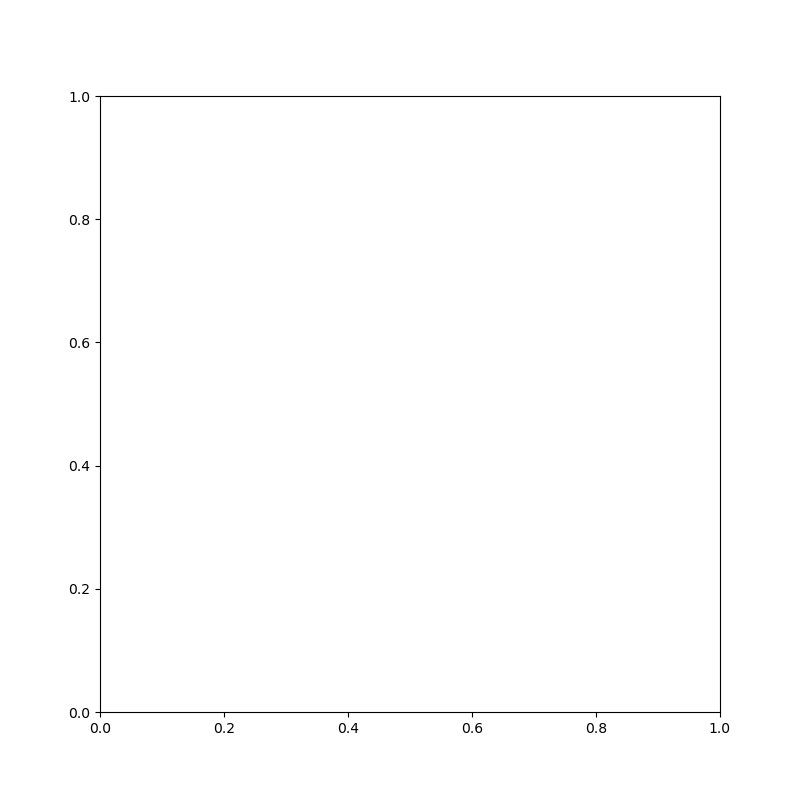

In [87]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot()
t1=tiempo[::scale]*(1/86400)

def init():
    ax.celar()
    ax.set_xlim(-5e8,5e8)
    ax.set_ylim(-5e8,5e8)
    
def Update(i):
    init()
    ax.set_title("t = {:.4f} días"%(t1[i]))
    ax.scatter(0,0,color="blue")
    ax.scatter(x_luna[::scale][i],y_luna[::scale][i],color="gray")
    ax.scatter(x_satelite[::scale][i],y_satelite[::scale][i],color="red")
    

    
Animation = anim.FuncAnimation(fig,Update,frames=len(tiempo[::scale]),init_func=init)
